# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [3]:
#| hide
from nbdev.showdoc import *

In [60]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize_scalar
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool

import functools

from fastcore.test import *
from tqdm import tqdm


In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
#| export 

class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 1, # Mass function power law index
                m_min: float = 1e-15, # Minimum mass in Msun
                m_max: float = 1e-3, # Maximum mass in Msun
                mw_model: MilkyWayModel = None,
                m31_model: M31Model = None, 
                l = None, # Galactic longitude
                b = None, # Galactic latitude
                u_t = 1, #threshold impact parameter in point-source limit
                ds = 770,
                ):
        """
        Initialize the PBH population
        """

        self.ut_interp = ut_func_new

        self.p = p
        #Define range of power law we want to consider
        self.m_min = m_min
        self.m_max = m_max
        self.M_norm = 1 #solar mass
        self.Z = self.pl_norm()
        self.Zprime = self.dN_dM_norm()

        # Instantiate or use existing MilkyWayModel and M31Model
        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)

        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b
        self.u_t = u_t
        self.ds = ds

    
    def __str__(self) -> str:
        return f"FFP with power law dN / dlogM ~ m^-{self.p}"
    __repr__ = __str__

    def dN_dM(self, M, M_norm, p):
        return (M/M_norm)**(-p-1) / M_norm
    
    def dN_dM_wrapper(self, M):
        return self.dN_dM(M, self.M_norm, self.p)

    def dN_dM_norm(self):
        return 1/abs(nquad(self.dN_dM_wrapper,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3, self.m_min*1e6, self.m_max]})[0])
    
    def f_m(self, M):
        return self.dN_dM_wrapper(M)*self.Zprime

    def dN_dlogM(self, A, log10M, M_norm, p):
        M = 10**log10M
        return A * (M/self.M_norm)**-p
    
    def dN_dlogM_wrapper(self, M):
        return self.dN_dlogM(1, M, self.M_norm, self.p)
    
    def pl_norm(self):
        return 1/abs(nquad(self.dN_dlogM_wrapper,[[np.log10(self.m_min), np.log10(self.m_max)]], opts={'points': [np.log10(self.m_min), np.log10(self.m_min*1e3), np.log10(self.m_max*1e3)]})[0])

    def mass_func(self, log10m):
        #M_norm = 1 solar mass for now. This is dN/dlogM
        m = 10**log10m
        return self.Z * (m/1)**-self.p

    def differential_rate_integrand(self, umin, d, t, mf, model, finite=False, v_disp=None, t_e=False, tmax=np.inf, tmin=0):
        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d, mf) if finite else self.u_t
        if ut <= umin:
            return 0
        if t_e: 
            #Calculate radial velocity in terms of einstein crossing time
            v_rad = einstein_rad(d, mf, self.ds) * kpctokm / (t * htosec) 
            #crossing duration determined by extent of source in extreme finite limit
            t_duration = max(ut, self.umin_upper_bound(d, mf)) * 2 * einstein_rad(d, mf) * kpctokm / v_rad / htosec #event duration in hours

            if t_duration > tmax or t_duration < tmin:
                return 0     
        else:
            #Calculate radial velocity in terms of event duration (t_fwhm)
            v_rad = velocity_radial(d, mf, umin, t * htosec, ut) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_stars(r)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                model.density_stars(d, self.l, self.b) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate(self, t, integrand_func, finite=False, epsabs = 1.49e-08, epsrel = 1.49e-08):
        # #rewrite using tplquad?
        # num = 40  # number of discretization points, empirically, result levels off for >~ 40
        # mf_values = np.linspace(np.log10(self.m_min), np.log10(self.m_max), num=num)

        # result = 0
        # for i in range(num):
        #     mf = mf_values[i]
        #     if i == 0:  # for the first point
        #         dm = mf_values[i+1] - mf_values[i]
        #     elif i < num - 1:  # for middle points
        #         dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
        #     else:  # for the last point
        #         dm = mf_values[i] - mf_values[i-1]
        #     if finite:
        #         single_result, error = dblquad(integrand_func, 
        #                                     # 0, 10, 
        #                                     0, self.d_upper_bound(10**mf),
        #                                     lambda d: 0, 
        #                                     lambda d: self.umin_upper_bound(d, 10**mf),
        #                                     args=(10**mf, t),
        #                                     epsabs=epsabs,
        #                                     epsrel=epsrel,
        #                                     )
        #     else:
        #         single_result, error = dblquad(integrand_func,
        #                                        #Without finite size effects, integral blows up at M31 center
        #                                     0, self.ds,
        #                                     lambda d: 0, 
        #                                     lambda d: self.u_t,
        #                                     args=(10**mf, t),
        #                                     epsabs=epsabs,
        #                                     epsrel=epsrel,
        #                                     )
            
        #     result += single_result * ((10**mf/1) ** -self.p) * dm # multiply by mass function and by dlogm. This is for dN/dlogM

        # result *= self.Z  # normalization
        # return result


        def inner_integrand(u, d, m):
            return integrand_func(u, d, m, t)
            
        # Second integral (over u) - bounds given by d
        def second_integral(d, m):
            point = self.sticking_point(m)

            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d, m)
            else:
                u_min, u_max = 0, self.u_t

            result, error = quad(inner_integrand, u_min, u_max, args=(d, m), epsabs=epsabs, epsrel=epsrel, points=[point])

            return result
            
        # Third integral (over d)
        def third_integral(m):
            if finite:
                d_min, d_max = 0, self.d_upper_bound(m)
            else:
                d_min, d_max = 0, self.ds

            result, error = quad(second_integral, d_min, d_max, args=(m,), epsabs=epsabs, epsrel=epsrel)
            return result
        
        # Outermost integral (over m in log scale)
        def integrand_logm(logm):
            m = 10**logm
            result = third_integral(m)
            return result * ((m/self.M_norm) ** -self.p)  # multiply by mass function. This is for dN/dlogM

        logm_min = np.log10(self.m_min)
        logm_max = np.log10(self.m_max)

        result, error = quad(integrand_logm, logm_min, logm_max, epsabs=epsabs, epsrel=epsrel)

        result *= self.Z  # normalization
        return result

    
    def differential_rate_mw(self, t, finite=True, v_disp=None, t_e=False, epsabs = 1.49e-08, epsrel = 1.49e-08, tmax=np.inf, tmin=0):
        def integrand_func(umin, d, mf, t):
            return self.differential_rate_integrand(umin, d, t, mf, self.mw_model, finite=finite, v_disp=v_disp, t_e=t_e, tmax=tmax, tmin=tmin)
        return self.differential_rate(t, integrand_func, finite=finite, epsabs=epsabs, epsrel=epsrel)

    def differential_rate_m31(self, t, finite=True, v_disp=None, epsabs = 1.49e-08, epsrel = 1.49e-08,):
        def integrand_func(umin, d, mf, t):
            return self.differential_rate_integrand(umin, d, t, mf, self.m31_model, finite=finite, v_disp=v_disp)
        return self.differential_rate(t, integrand_func, finite=finite, epsabs=epsabs, epsrel=epsrel)

    def differential_rate_mw_mass(self, m, finite=True, v_disp=None, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):
        def integrand_func(umin, d, t, mf):
            return self.differential_rate_integrand(umin, d, t, mf, self.mw_model, finite=finite, v_disp=v_disp)
        return self.differential_rate_mass(m, integrand_func, finite=finite, tcad=tcad, tobs=tobs, epsabs = epsabs, epsrel = epsrel, efficiency=efficiency, monochromatic=monochromatic)
    
    def differential_rate_m31_mass(self, m, finite=True, v_disp=None, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):
        def integrand_func(umin, d, t, mf):
            return self.differential_rate_integrand(umin, d, t, mf, self.m31_model, finite=finite)
        return self.differential_rate_mass(m, integrand_func, finite=finite, tcad=tcad, tobs=tobs, epsabs = epsabs, epsrel = epsrel, efficiency=efficiency, monochromatic=monochromatic)

    def umin_upper_bound(self, d, m):
        rho = rho_func(m, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))

    def d_upper_bound(self, m):
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d, m) == 0:
                return d
        return self.ds
    
    def sticking_point(self,m):
        #Determine where u_t is maximized. This speeds up the integral in m31
        result = minimize_scalar(lambda d:-self.umin_upper_bound(d, m), bounds=(0, self.ds), method='bounded')
        if result.success:
            return result.x[0] if isinstance(result.x, (list, np.ndarray)) else result.x
        else:
            return self.ds
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]
    
    def differential_rate_mass(self, m, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):        
        
        if efficiency is None:
            def efficiency(t):
                return 1

        point = self.sticking_point(m)

        def inner_integrand(u, d, t, m):
            return integrand_func(u, d, t, m) * efficiency(t)
            
        # Second integral (over u) - bounds given by d
        def second_integral(d, t, m):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d, m)[0]
            else:
                u_min, u_max = 0, self.u_t
            result, error = quad(inner_integrand, u_min, u_max, args=(d, t, m), epsabs=epsabs, epsrel=epsrel, points=[point])
            return result
            
        # Third integral (over d)
        def third_integral(t, m):
            if finite:
                d_min, d_max = 0, self.d_upper_bound(m)
            else:
                d_min, d_max = 0, self.ds

            result, error = quad(second_integral, d_min, d_max, args=(t, m), epsabs=epsabs, epsrel=epsrel)
            return result
                
        # Outermost integral (over t)
        t_min = tcad
        t_max = tobs
        result, error = quad(third_integral, t_min, t_max, args=(m,), epsabs=epsabs, epsrel=epsrel)
        
        if monochromatic:
            return result
        return result * self.f_m(m)



In [63]:
p = 1.0
# f = Ffp(p, l = 1.0, b = -1.03, ds=8.5, u_t = 2)
f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=2.5e-6, m_max=3.5e-6)


In [33]:
f.umin_upper_bound(1, 3e-6)

array([3.5014054])

In [30]:
magnification(3.5)

1.009997124512126

In [54]:
u_t_arr = np.linspace(0.1, 10, 20)
diff_rate_earth_log_un_1 = []
for u_t in tqdm(u_t_arr):
    f.u_t = u_t
    diff_rate_earth_log_un_1.append(np.log10(f.differential_rate_total(10, finite=True)))
diff_rate_earth_log_un_1 = np.array(diff_rate_earth_log_un_1)

100%|██████████| 20/20 [03:32<00:00, 10.63s/it]


Text(0.5, 1.0, 'Earth mass')

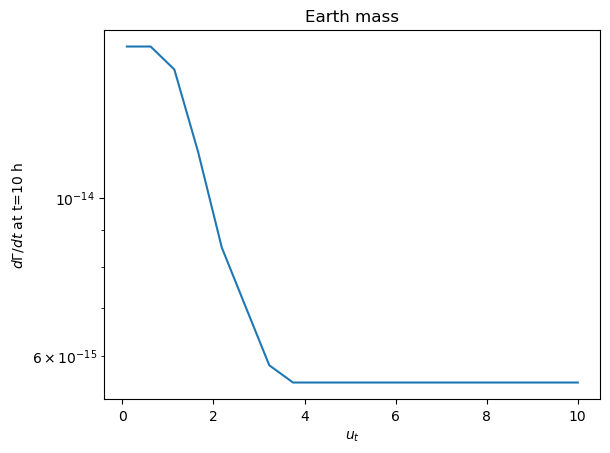

In [55]:
plt.plot(u_t_arr, 10**diff_rate_earth_log_un_1)
plt.yscale('log')
plt.xlabel(r'$u_t$')
plt.ylabel(r'$d\Gamma/dt$ at t=10 h')
plt.title(r'Earth mass')

In [105]:
#new
f.differential_rate_mw(10, finite=True, v_disp=220)

2.834948673444066e-13

In [106]:
ts = np.logspace(np.log10(0.25), np.log10(24*72*6), 30)
dgdt_arr = np.array([f.differential_rate_mw(t, finite=True, v_disp=220) for t in tqdm(ts)])


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:40<00:00,  5.34s/it]


In [115]:
#new
f.differential_rate_mw_mass(3e-6, finite=True, v_disp=220, tcad=0.25, tobs=24*72*6, monochromatic=True, epsabs=0, epsrel=1e-1)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_1335/232200059.py:246: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t, m), epsabs=epsabs, epsrel=epsrel, points=[point])


0.07834823484653951


1.0877740384154337e-11

In [108]:
dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')
quad(dgdt_interp, 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
#I would expect this to be close to the monochromatic result, which it is!

1.125927998877597e-11

## Log normal comparison to Johnson

In [67]:
mass_arr = np.logspace(-2, 4, 7)*3e-6
ts = np.logspace(np.log10(0.25), np.log10(24*72*6), 30)


In [65]:
roman_df = pd.read_csv('../examples/roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))


In [69]:
result_arr = np.zeros(len(mass_arr))
for i, m in enumerate(tqdm(mass_arr)):
    # f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 3.45, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    dgdt_arr = np.array([f.differential_rate_mw(t, finite=True, v_disp=220) for t in ts])
    dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

    rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
    result_arr[i] = rate * 24*72*6 * 2.4e8

 43%|████▎     | 3/7 [19:39<24:57, 374.32s/it]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14517/3535331868.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
100%|██████████| 7/7 [26:51<00:00, 230.19s/it]


In [96]:
result_arr_point_1 = np.zeros(len(mass_arr))
for i, m in enumerate(tqdm(mass_arr)):
    f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    # f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 3.45, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    # f = Ffp(0, l = 1.0, b = -1.03, ds=8.5, u_t = 3.0, m_min=m*10**(-0.5), m_max=m*10**(0.5))
    dgdt_arr = np.array([f.differential_rate_mw(t, finite=False, v_disp=220) for t in ts])
    dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

    rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
    result_arr_point_1[i] = rate * 24*72*6 * 2.4e8

 43%|████▎     | 3/7 [01:40<02:15, 33.82s/it]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14517/3939466292.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
100%|██████████| 7/7 [05:04<00:00, 43.52s/it]


In [97]:
result_arr_point_1

array([6.66058132e-01, 4.51597126e+00, 1.91777526e+01, 6.94530989e+01,
       2.29975935e+02, 7.40354621e+02, 2.36208973e+03])

In [99]:
our_ut_1_finite = np.array([0.054581, 1.747823, 18.989170 , 72.575551, 233.820611, 744.041794, 2372.639453])
our_ut_1_point =  np.array([6.66058132e-01, 4.51597126e+00, 1.91777526e+01, 6.94530989e+01,2.29975935e+02, 7.40354621e+02, 2.36208973e+03])
result_arr_point_3 = np.array([4.19731590e+00, 1.84469580e+01, 6.56940092e+01, 2.17129007e+02, 7.01789494e+02, 2.24181653e+03, 7.11845702e+03])
result_arr_point_35 = np.array([5.09027157e+00, 2.15841384e+01, 7.61618731e+01, 2.51482464e+02, 8.08879645e+02, 2.57807882e+03, 8.16249999e+03])


In [86]:
rho_func(3e-6*1e-2, 8.5/2, 8.5)

3.2421065531473174

In [87]:
ut_func_new(3.24, 1.01)

array([4.56896632])

In [89]:
magnification(3)

1.0169503597462535

In [101]:
johnson_logn_new = np.array([0.306, 4.49, 22.1, 87.1, 313, 1025, 3329])
johnson_fid_new = np.array([0.611, 8.97, 44.2, 108, 72.3, 44.1, 26.7])
N_power_our_fid_arr= []
for m in mass_arr:
    N_power_our_fid_arr.append(10*(m/(3e-6))**(-1))
N_power_our_fid_arr = np.array(N_power_our_fid_arr)

N_power_new_arr= []
for m in mass_arr:
    N_power_new_arr.append(0.24*(m/(95*3e-6))**(-0.73))
N_power_new_arr = np.array(N_power_new_arr)


In [103]:
our_ut_1_point/johnson_logn_new

array([2.17666056, 1.00578424, 0.86777161, 0.79739494, 0.7347474 ,
       0.72229719, 0.70954933])

In [104]:
our_ut_1_finite/johnson_logn_new

array([0.17836928, 0.38927016, 0.85923846, 0.83324398, 0.74703071,
       0.72589443, 0.71271837])

In [169]:
df = pd.DataFrame({'m [M_earth]': np.round(mass_arr/3e-6,2), 'Our Log-Uniform': result_arr, 'Johnson Log-Uniform': johnson_logn_new, 'Our Fiducial': N_power_our_fid_arr*result_arr, 'Johnson Fiducial Power': johnson_logn_new*N_power_new_arr})
print(df)

   m [M_earth]  Our Log-Uniform  Johnson Log-Uniform  Our Fiducial  \
0         0.01         0.054581                0.306     54.580964   
1         0.10         1.747823                4.490    174.782304   
2         1.00        18.989170               22.100    189.891703   
3        10.00        72.575551               87.100     72.575551   
4       100.00       233.820611              313.000     23.382061   
5      1000.00       744.041794             1025.000      7.440418   
6     10000.00      2372.639453             3329.000      2.372639   

   Johnson Fiducial Power  
0               58.839761  
1              160.766595  
2              147.347152  
3              108.135335  
4               72.359209  
5               44.123844  
6               26.684758  


In [73]:
result_arr

array([8.19674456e+00, 3.34375141e+01, 8.78681152e+01, 2.57978574e+02,
       8.14157860e+02, 2.59035151e+03, 8.19974070e+03])

In [94]:
result_arr_point_3/np.array([0.0545, 1.7478, 18.99, 72.58, 233.82, 744.04, 2373])

array([77.01497063, 10.55438725,  3.45940017,  2.9915818 ,  3.00140918,
        3.01303228,  2.99977118])

In [ ]:
#full power law comparison
M_norm = 3e-6
Z_fiducial = 10
f = Ffp(1, l = 1.0, b = -1.03, ds=8.5, u_t = 1, m_min=1e-12, m_max= 1e-1)
z_earth =  Z_fiducial/(f.Z*(M_norm/f.M_norm)**(-p))
dgdt_arr = np.array([f.differential_rate_mw(t, finite=True, v_disp=220) for t in tqdm(ts)])
dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

rate = quad(lambda t: dgdt_interp(t) * roman_efficiency(t), 0.25, 24*72*6, epsabs=0, epsrel=1e-1)[0]
print(rate * 24*72*6 * 2.4e8 * z_earth)

In [ ]:
#Should be close to for power-law calc and log-uniform calc to agree
sum(N_power_our_fid_arr*result_arr)

525.0256409207203

Text(0, 0.5, 'Number of Events')

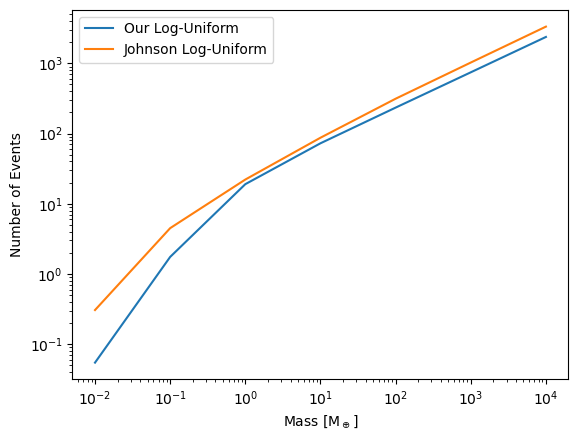

In [146]:
plt.loglog(mass_arr/3e-6, result_arr, label='Our Log-Uniform')
plt.loglog(mass_arr/3e-6, johnson_logn_new, label='Johnson Log-Uniform')
plt.legend()
plt.xlabel('Mass [M$_\oplus$]')
plt.ylabel('Number of Events')


In [116]:
#Test that the mass function is normalized correctly
test_close(abs(nquad(f.mass_func,[[np.log10(f.m_min), np.log10(f.m_max)]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]), 1, eps=1e-3)

In [117]:
#Test that the mass function is normalized correctly
test_close(abs(nquad(f.f_m,[[f.m_min, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e6, f.m_max]})[0]), 1, eps=1e-3)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()